# RBIG Demo

In [19]:
import sys
sys.path.insert(0, '/home/emmanuel/code/py_packages/rbig/')
sys.path.insert(0, '/home/emmanuel/code/rbig/')
sys.path.insert(0, '/Users/eman/Documents/code_projects/rbig/')

import numpy as np
import warnings
from time import time
from rbig.rbig import RBIG, entropy
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings('ignore') # get rid of annoying warnings

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Toy Data

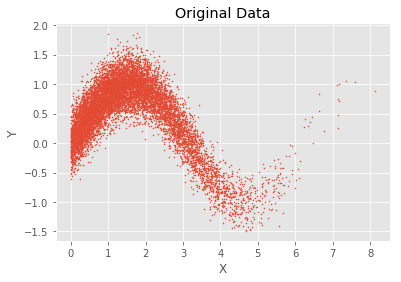

In [20]:
seed = 123
rng = np.random.RandomState(seed=seed)

num_samples = 10000
x = np.abs(2 * rng.randn(1, num_samples))
y = np.sin(x) + 0.25 * rng.randn(1, num_samples)
data = np.vstack((x, y)).T

fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Original Data')
plt.show()

## RBIG Fitting

In [101]:
%%time 

n_layers = 1000
rotation_type = 'pca'
random_state = 123
zero_tolerance = 100

# Initialize RBIG class
rbig_model = RBIG(n_layers=n_layers, rotation_type=rotation_type, 
                  random_state=random_state, zero_tolerance=zero_tolerance)

# fit model to the data
rbig_model.fit(data);

CPU times: user 25.5 s, sys: 5 ms, total: 25.5 s
Wall time: 1.61 s


### Transform Data into Gaussian

(10000, 2)


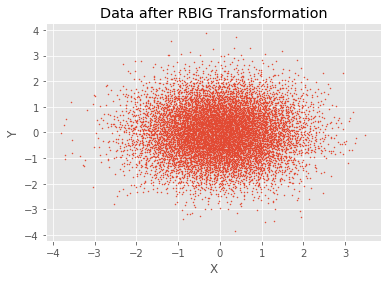

In [102]:
# transform data
data_trans = rbig_model.transform(data)
print(data_trans.shape)
fig, ax = plt.subplots()
ax.scatter(data_trans[:, 0], data_trans[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Data after RBIG Transformation')
plt.show()

### Information Reduction

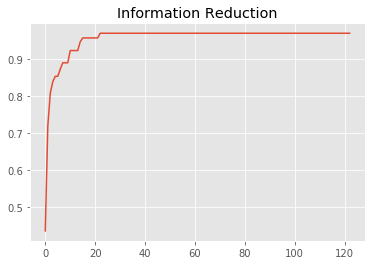

In [95]:
residual_info = rbig_model.residual_info

fig, ax = plt.subplots()
ax.plot(np.cumsum(rbig_model.residual_info))
ax.set_title('Information Reduction')
plt.show()

### Generated Synthetic Data

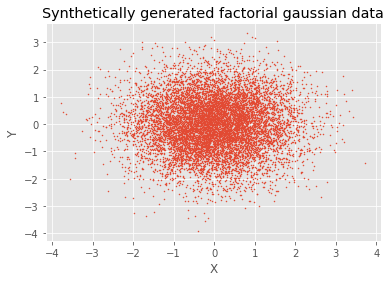

In [85]:
data_synthetic = rng.randn(data.shape[0], data.shape[1])

fig, ax = plt.subplots()
ax.scatter(data_synthetic[:, 0], data_synthetic[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Synthetically generated factorial gaussian data')
plt.show()

### Synthesize New Data from RBIG Model

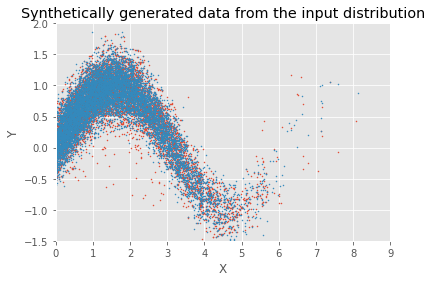

In [86]:
data_original_synthetic = rbig_model.inverse_transform(data_synthetic)

fig, ax = plt.subplots()
ax.scatter(data_original_synthetic[:, 0], data_original_synthetic[:, 1], s=1)
ax.scatter(data[:, 0], data[:, 1], s=1)

ax.set_ylim([-1.5, 2.0])
ax.set_xlim([0.0, 9.0])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Synthetically generated data from the input distribution')
plt.show()

### Check Residuals: Transformation $\rightarrow$ Inverse Transformation

In [87]:
data_inverted = rbig_model.inverse_transform(data_trans)
residual = np.abs(data - data_inverted).sum().sum()

print(f'Residual from Original and Transformed: {residual:.2e}')

Residual from Original and Transformed: 3.01e+02


### Jacobian

In [88]:
jacobian = rbig_model.jacobian(data, return_X_transform=False)

print(jacobian.shape)

print(f"Jacobian - min: {jacobian.min():.3e}, max: {jacobian.max():.3e}")

(10000, 2, 2)
Jacobian - min: -1.423e+10, max: 1.176e+13


### Estimating Probabilities with RBIG

In [89]:
prob_input, prob_gauss = rbig_model.predict_proba(data, domain='both', n_trials=1)
print(f"Prob Input - min: {prob_input.min():.3e}, max: {prob_input.max():.3e}")
print(f"Prob Gauss - min: {prob_gauss.min():.3e}, max: {prob_gauss.max():.3e}")
print(f"Det:: {rbig_model.det_jacobians:.3e}")


Prob Input - min: 1.583e-21, max: 2.466e+00
Prob Gauss - min: 9.490e-05, max: 1.592e-01
Det:: -4.492e+00


### Original Data with Probabilities

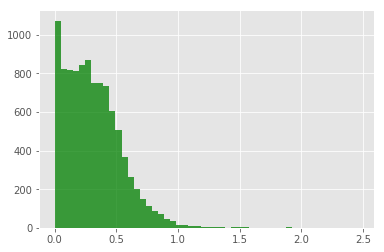

In [90]:
fig, ax = plt.subplots()
ax.hist(prob_input, 50, facecolor='green', alpha=0.75)
plt.show()



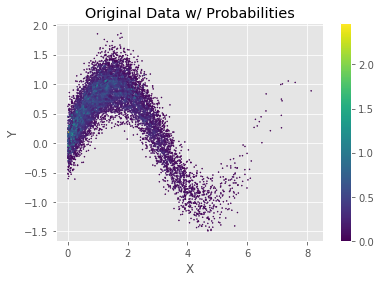

In [91]:
fig, ax = plt.subplots()

h = ax.scatter(data[:, 0], data[:, 1], s=1, c=prob_input)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.colorbar(h)
ax.set_title('Original Data w/ Probabilities')
plt.show()

### Probability in Gaussian Domain

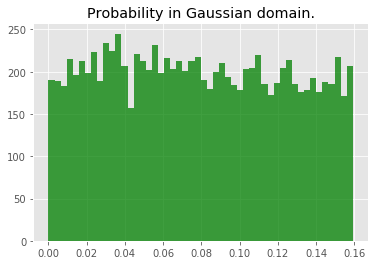

In [92]:
# Plot the probability of the data in the Gaussian Domain
fig, ax = plt.subplots()

n, bins, patches = ax.hist(prob_gauss, 50, facecolor='green', alpha=0.75)
ax.set_title('Probability in Gaussian domain.')
plt.show()

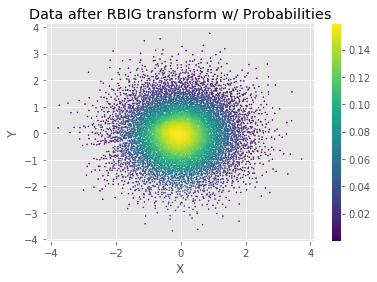

In [80]:
# Plot the Probabilities of the data using colors
fig, ax = plt.subplots()
g = ax.scatter(data_trans[:, 0], data_trans[:, 1],
               s=1, c=prob_gauss)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Data after RBIG transform w/ Probabilities')
plt.colorbar(g)
plt.show()